# MATH 441 Optimization Problems

In [2]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.optimize import linprog

## Mathematical Modelling Process

* Problem statement
* Define variables
* Identify constraints and make assumptions
* Build solutions
* Analyze the model
* Report results

## Transportation (aka Optimal Transport)

### Problem Statement

A company has products at different storage locations (called supply nodes) and needs to deliver the product to several customer locations (called demand nodes). How do we move supply to meet the demand at minimal cost?

### Define Variables

* $x_{ij}$ is the number of units to deliver from supply node $i$ to demand node $j$
* $c_{ij}$ is the cost per unit to deliver from supply node $i$ to demand node $j$
* $s_i$ is the number of units available at supply node $i$
* $d_j$ is the number of units required at demand node $j$
* $m$ is the number of supply nodes
* $n$ is the number of demand nodes

### Identify Constraints and Make Assumptions

* Total supply is equal to the total demand
* Cost to deliver supply is proportional to distance between nodes
* Product quantities are continuous (not discrete)

### Build Solutions

The total transportation cost is

$$
\sum_{i=0}^{m-1} \sum_{j=0}^{n-1} c_{ij} x_{ij}
$$

The supply constraint for each supply node:

$$
\sum_{j=0}^{n-1} x_{ij} = s_i \ , \ \ i = 0,\dots,m-1
$$

The demand constraint for each demand node:

$$
\sum_{i=0}^{m-1} x_{ij} = d_j \ , \ \ j = 0,\dots,n-1
$$

The total demand is equal to the total supply:

$$
\sum_{i=0}^{m-1} s_i = \sum_{j=0}^{n-1} d_j
$$

### Compute Solutions with CVXPY

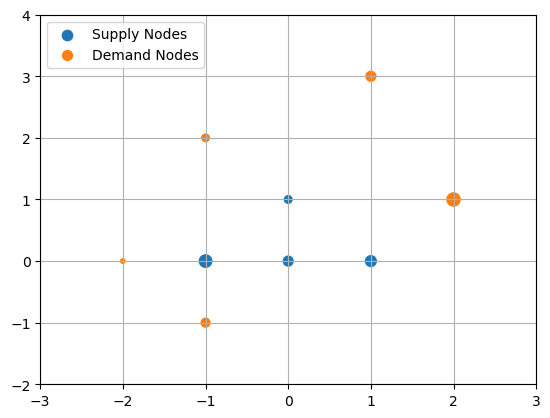

In [30]:
s_nodes = np.array([(0.,0.),(1.,0.),(0.,1.),(-1.,0.)])
s = np.array([5.,6.,3.,8.])
d_nodes = np.array([(2.,1.),(-2.,0.),(-1.,2.),(1.,3.),(-1.,-1.)])
d = np.array([9.,1.,3.,5.,4.])

assert np.sum(s) == np.sum(d)

plt.scatter(s_nodes[:,0],s_nodes[:,1],s=10*s)
plt.scatter(d_nodes[:,0],d_nodes[:,1],s=10*d)

plt.legend(['Supply Nodes','Demand Nodes'],loc='upper left')
plt.xlim([-3,3]), plt.ylim([-2,4]), plt.grid(True)
plt.show()

Compute the cost matrix $C = [c_{ij}]$:

In [31]:
m = len(s)
n = len(d)

C = np.zeros([m,n])
for i in range(m):
    for j in range(n):
        # Distance from supply node i to demand node j
        C[i,j] = np.linalg.norm(d_nodes[j,:] - s_nodes[i,:])

print(C)

[[2.23606798 2.         2.23606798 3.16227766 1.41421356]
 [1.41421356 3.         2.82842712 3.         2.23606798]
 [2.         2.23606798 1.41421356 2.23606798 2.23606798]
 [3.16227766 1.         2.         3.60555128 1.        ]]


Compute the solution using `CVXPY`:

In [32]:
X = cp.Variable((m,n))
obj = cp.Minimize(cp.sum(cp.multiply(C,X)))
constraint1 = [cp.sum(X[i,:]) == s[i] for i in range(m)]
constraint2 = [cp.sum(X[:,j]) == d[j] for j in range(n)]
constraint3 = [X >= 0]
constraints = constraint1 + constraint2 + constraint3
prob = cp.Problem(obj,constraints)

In [33]:
prob.solve()

39.22624459495728

In [34]:
X.value.round(3)

array([[ 3.,  0.,  0.,  2.,  0.],
       [ 6., -0.,  0.,  0., -0.],
       [ 0.,  0.,  0.,  3.,  0.],
       [ 0.,  1.,  3.,  0.,  4.]])

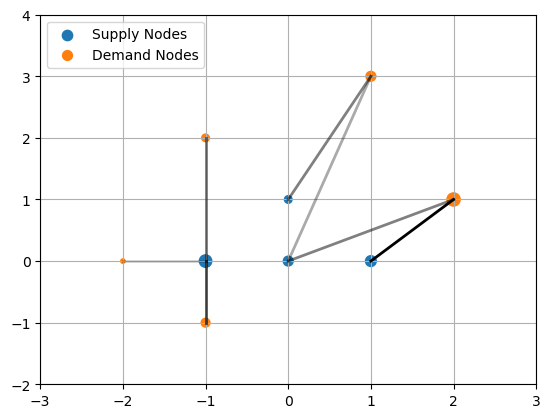

In [35]:
plt.scatter(s_nodes[:,0],s_nodes[:,1],s=10*s)
plt.scatter(d_nodes[:,0],d_nodes[:,1],s=10*d)
max_X = X.value.max()

for i in range(m):
    for j in range(n):
        plt.plot([s_nodes[i,0],d_nodes[j,0]],[s_nodes[i,1],d_nodes[j,1]],c='k',lw=2,alpha=np.abs(X.value[i,j])/max_X)

plt.legend(['Supply Nodes','Demand Nodes'],loc='upper left')
plt.xlim([-3,3]), plt.ylim([-2,4]), plt.grid(True)
plt.show()

### Standard Form

What is the vector of decision variables? It's a matrix $X = [x_{ij}]$. How do we translate this into $A \mathbf{x} = \mathbf{b}$? Flatten the matrix $X$ into the vector $\mathbf{x}$.

In [36]:
X = np.array([[0,1,2,3],[4,5,6,7],[8,9,10,11]])
X

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [37]:
x = X.flatten()
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [38]:
x = x.reshape((3,4))
x

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

Let's assume $m = 3$ and $n = 4$. Define the vector $\mathbf{x}$ as the "flattened" matrix $X$:

$$
X = \begin{bmatrix} x_{0,0} & x_{0,1} & x_{0,2} & x_{0,3} \\ x_{1,0} & x_{1,1} & x_{1,2} & x_{1,3} \\ x_{2,0} & x_{2,1} & x_{2,2} & x_{2,3} \end{bmatrix}
\hspace{20mm}
\mathbf{x} = \begin{bmatrix} x_{0,0} \\ x_{0,1} \\ x_{0,2} \\ x_{0,3} \\ x_{1,0} \\ x_{1,1} \\ x_{1,2} \\ x_{1,3} \\ x_{2,0} \\ x_{2,1} \\ x_{2,2} \\ x_{2,3} \end{bmatrix}
$$

The first supply constraint is: $\sum_{j=0}^3 x_{0,j} = s_0$. What does the first row of $A$ look like?

$$
\begin{bmatrix} 1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \end{bmatrix}
$$

What about the rows for the other supply constraints: $\sum_{j=0}^3 x_{1,j} = s_1$ and $\sum_{j=0}^3 x_{2,j} = s_2$.

$$
\begin{bmatrix} 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 \end{bmatrix}
$$

$$
\begin{bmatrix} 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 \end{bmatrix}
$$

This is the [kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) of the identity matrix $I$ (of size 3) and the transpose of the vector $\mathbf{e}$ of all 1s (of length 4).

$$
I \otimes \mathbf{e}^T =
\begin{bmatrix}
1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1
\end{bmatrix}
$$

In [39]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [40]:
np.ones(4)

array([1., 1., 1., 1.])

In [41]:
np.kron(np.eye(3),np.ones(4))

array([[1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.]])

What do the demand constraints look like in the matrix $A$?

The first demand constraint is: $\sum_{i=0}^2 x_{i,0} = d_0$ or $x_{0,0} + x_{1,0} + x_{2,0} = d_0$.

$$
\mathbf{x} = \begin{bmatrix} x_{0,0} \\ x_{0,1} \\ x_{0,2} \\ x_{0,3} \\ x_{1,0} \\ \vdots \\ x_{2,3} \end{bmatrix}
$$

$$
\mathbf{e}^T \otimes I =
\begin{bmatrix}
1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1
\end{bmatrix}
$$

This is also a kronecker product but this time $\mathbf{e}$ is the vector of 1s of length 3 and $I$ is the identiy matrix of size 4.

In [42]:
np.kron(np.ones(3),np.eye(4))

array([[1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.]])

In [43]:
m = 3; n = 4;
A1 = np.kron(np.eye(m),np.ones(n))
A2 = np.kron(np.ones(m),np.eye(n))
A = np.vstack([A1,A2])

In [44]:
A

array([[1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.]])

The vector $\mathbf{b}$ is the supply vector and demand vector stacked.
$$
\mathbf{b} = \begin{bmatrix} \mathbf{s} \\ \mathbf{d} \end{bmatrix}
$$

What about the cost function $\mathbf{c}$? Create a matrix $C = [c_{ij}]$ where $c_{ij}$ is the distance from supply node $i$ to demand node $j$, and then let $\mathbf{c}$ be the flattened vector.

Let's do an example.

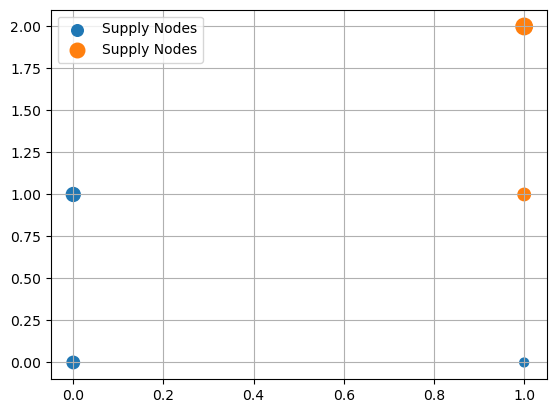

In [45]:
s_nodes = np.array([(0,0),(1,0),(0,1)])
s = np.array([4,2,5])
plt.scatter(s_nodes[:,0],s_nodes[:,1],s=20*s,label='Supply Nodes')

d_nodes = np.array([(1,1),(1,2)])
d = np.array([4,7])
plt.scatter(d_nodes[:,0],d_nodes[:,1],s=20*d,label='Supply Nodes')

plt.grid(True), plt.legend()
plt.show()

In [46]:
m = 3; n = 2;
A1 = np.kron(np.eye(m),np.ones(n))
A2 = np.kron(np.ones(m),np.eye(n))
A = np.vstack([A1,A2])
A

array([[1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1.],
       [1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 1.]])

In [47]:
b = np.hstack([s,d])
b

array([4, 2, 5, 4, 7])

In [48]:
C = np.zeros((m,n))
for i in range(m):
    for j in range(n):
        C[i,j] = np.linalg.norm(s_nodes[i,:] - d_nodes[j,:])

In [49]:
C

array([[1.41421356, 2.23606798],
       [1.        , 2.        ],
       [1.        , 1.41421356]])

In [50]:
c = C.flatten()

In [51]:
result = linprog(c,A_eq=A,b_eq=b)

In [52]:
X = result.x.reshape((m,n))
X

array([[2., 2.],
       [2., 0.],
       [0., 5.]])

This makes sense since supply node 2 is closest to demand node 1 with demand 7 and so all 5 units at supply node 2 go to demand node 1 and there is nothing left to move from supply node 2 to demand node 0: $x_{2,1} = 5$ and $x_{2,0}=0$.

Then move 2 units form supply node 0 to demand node 1 and the remainder to demand 0: $x_{0,1} = 2$ and $x_{0,0} = 2$.

Finally $x_{1,0} = 2$ and $x_{1,1} = 0$.

### Compare with CVXPY

Let's do the first example again but using `linprog` and compare.

In [53]:
s_nodes = np.array([(0.,0.),(1.,0.),(0.,1.),(-1.,0.)])
s = np.array([5.,6.,3.,8.])
d_nodes = np.array([(2.,1.),(-2.,0.),(-1.,2.),(1.,3.),(-1.,-1.)])
d = np.array([9.,1.,3.,5.,4.])

assert np.sum(s) == np.sum(d)

m = len(s)
n = len(d)

C = np.zeros([m,n])
for i in range(m):
    for j in range(n):
        # Distance from supply node i to demand node j
        C[i,j] = np.linalg.norm(d_nodes[j,:] - s_nodes[i,:])

A1 = np.kron(np.eye(m),np.ones(n))
A2 = np.kron(np.ones(m),np.eye(n))
A = np.vstack([A1,A2])

c = C.flatten()
b = np.hstack([s,d])

result = linprog(c,A_eq=A,b_eq=b)

result.x.reshape((m,n))

array([[ 3.,  0.,  0.,  2.,  0.],
       [ 6.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  3.,  0.],
       [ 0.,  1.,  3., -0.,  4.]])

Same solution!